In [1]:
!pip install imbalanced-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import joblib
import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42


In [3]:
df = pd.read_csv('data\Loan_default.csv')
df.head()


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [4]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())
print("\nClass Distribution:\n", df['Default'].value_counts())


Shape: (255347, 18)

Columns: ['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']

Missing Values:
 LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

Class Distribution:
 Default
0    225694
1     29653
Name: count, dtype: int64


In [5]:
df = df.drop(columns=['LoanID'])
df.head()


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [6]:
X = df.drop(columns=['Default'])
y = df['Default']


In [7]:
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_cols, categorical_cols


(['Age',
  'Income',
  'LoanAmount',
  'CreditScore',
  'MonthsEmployed',
  'NumCreditLines',
  'InterestRate',
  'LoanTerm',
  'DTIRatio'],
 ['Education',
  'EmploymentType',
  'MaritalStatus',
  'HasMortgage',
  'HasDependents',
  'LoanPurpose',
  'HasCoSigner'])

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_cols),
    ('cat', cat_pipeline, categorical_cols)
])


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape


((204277, 16), (51070, 16))

In [10]:
def build_pipeline(model):
    return ImbPipeline([
        ('pre', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', model)
    ])


In [11]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Dictionary of required models
models = {
    "Logistic Regression": build_pipeline(
        LogisticRegression(max_iter=500, random_state=RANDOM_STATE)
    ),

    "Naive Bayes": build_pipeline(
        GaussianNB()
    ),

    "Decision Tree": build_pipeline(
        DecisionTreeClassifier(random_state=RANDOM_STATE)
    ),

    "Random Forest": build_pipeline(
        RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
    ),

    "XGBoost": build_pipeline(
        XGBClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.7,
            colsample_bytree=0.8,
            eval_metric="logloss",
            random_state=RANDOM_STATE
        )
    ),

    "KNN": build_pipeline(
        KNeighborsClassifier(n_neighbors=5)
    )
}


In [13]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd

# FIX: Define cv before using it
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

baseline_scores = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring='accuracy',
        cv=cv
    )
    
    baseline_scores[name] = scores.mean()
    print(f"CV Accuracy: {scores.mean():.4f}")

# Convert to Series and sort
pd.Series(baseline_scores).sort_values(ascending=False)



Training Logistic Regression...
CV Accuracy: 0.6820

Training Naive Bayes...
CV Accuracy: 0.6941

Training Decision Tree...
CV Accuracy: 0.7728

Training Random Forest...
CV Accuracy: 0.8802

Training XGBoost...
CV Accuracy: 0.8834

Training KNN...
CV Accuracy: 0.6506


XGBoost                0.883403
Random Forest          0.880241
Decision Tree          0.772828
Naive Bayes            0.694077
Logistic Regression    0.681976
KNN                    0.650646
dtype: float64

In [15]:
rf_model = build_pipeline(
    RandomForestClassifier(random_state=RANDOM_STATE)
)
rf_params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [2, 5]
}


In [17]:
from sklearn.model_selection import RandomizedSearchCV

rf_search = RandomizedSearchCV(
    rf_model,
    rf_params,
    n_iter=5,
    scoring='accuracy',
    cv=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

print("Best Params:", rf_search.best_params_)
print("Best CV Accuracy:", rf_search.best_score_)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Params: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__max_depth': 20}
Best CV Accuracy: 0.8729861929530135


In [18]:
# Fast & Correct Stacking Code

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Base estimators (FAST — removed SVM)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)),
    ('gb', GradientBoostingClassifier(n_estimators=150, random_state=RANDOM_STATE)),
    ('lr', LogisticRegression(max_iter=500))
]

# Stacking model
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500),
    n_jobs=-1
)

# Pipeline with preprocessing + SMOTE + Stacking
stack_pipeline = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('stack', stack_model)
])

# Train
stack_pipeline.fit(X_train, y_train)

# Predictions
y_stack_pred = stack_pipeline.predict(X_test)
y_stack_prob = stack_pipeline.predict_proba(X_test)[:, 1]

# Results
print("Stack Accuracy:", accuracy_score(y_test, y_stack_pred))
print("Stack AUC:", roc_auc_score(y_test, y_stack_prob))
print(classification_report(y_test, y_stack_pred))


Stack Accuracy: 0.8752300763657724
Stack AUC: 0.6225267178891762
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     45139
           1       0.34      0.08      0.13      5931

    accuracy                           0.88     51070
   macro avg       0.62      0.53      0.53     51070
weighted avg       0.83      0.88      0.84     51070



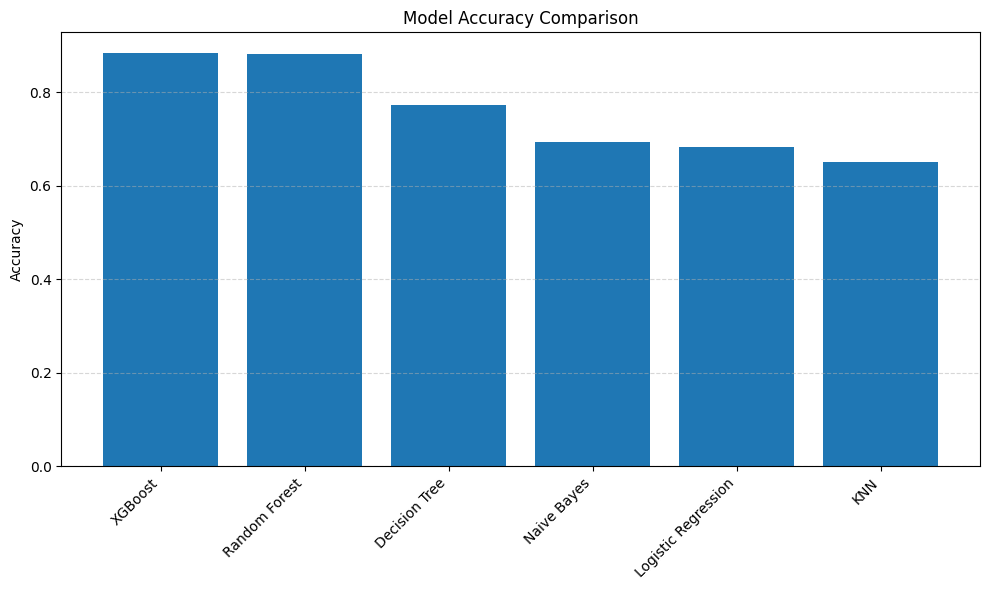

In [19]:
import matplotlib.pyplot as plt

# Convert scores to Series for easier plotting
score_series = pd.Series(baseline_scores).sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(score_series.index, score_series.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


In [2]:
# LOAD DATA
df = pd.read_csv("data\Loan_Default.csv")
df.head()


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [3]:
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())


In [4]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

if "Status" in numeric_features:
    numeric_features.remove("Status")
if "Status" in categorical_features:
    categorical_features.remove("Status")

numeric_features, categorical_features


(['Age',
  'Income',
  'LoanAmount',
  'CreditScore',
  'MonthsEmployed',
  'NumCreditLines',
  'InterestRate',
  'LoanTerm',
  'DTIRatio',
  'Default'],
 ['LoanID',
  'Education',
  'EmploymentType',
  'MaritalStatus',
  'HasMortgage',
  'HasDependents',
  'LoanPurpose',
  'HasCoSigner'])

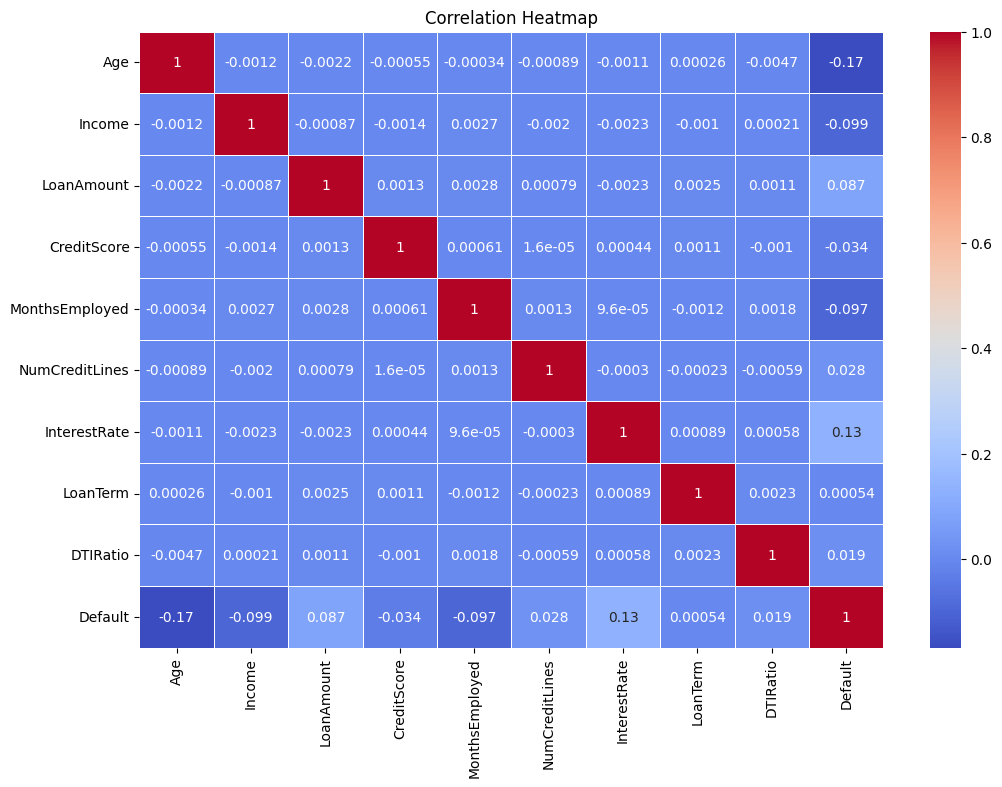

In [5]:
plt.figure(figsize=(12,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [7]:
# Copy dataframe
df_encoded = df.copy()
label_encoders = {}

# Encode categoricals
for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# X and y  (FIXED: "Status" → "Default")
X = df_encoded.drop("Default", axis=1)
y = df_encoded["Default"]

# Scale numeric features
scaler = StandardScaler()
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

X = df_encoded.drop("Default", axis=1)
y = df_encoded["Default"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [8]:
# DEFINE ALL MODELS
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')
}


In [13]:
# Fix continuous target --> convert into 0/1 classes
y_train = y_train.round().astype(int)
y_test = y_test.round().astype(int)


In [15]:
# Identify categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns

# Convert all categorical columns to numeric using Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col])


In [16]:
# 1. Encode categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# 2. Prepare data
X = df.drop("Default", axis=1)
y = df["Default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Fix target before training
y_train = y_train.round().astype(int)
y_test = y_test.round().astype(int)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

results = {}
trained_models = {}

for name, model in models.items():
    print("\n===============================")
    print(name)
    print("===============================")

    # Train model
    model.fit(X_train, y_train)
    trained_models[name] = model

    # Predict
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    # Print results
    print("\nAccuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Convert results to dataframe
results_df = pd.DataFrame(results.items(), columns=["Model", "Accuracy"])
results_df



Logistic Regression


c:\Users\saich\anaconda3\envs\tf-env\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy: 0.885275112590562
Confusion Matrix:
 [[45075    95]
 [ 5764   136]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     45170
           1       0.59      0.02      0.04      5900

    accuracy                           0.89     51070
   macro avg       0.74      0.51      0.49     51070
weighted avg       0.85      0.89      0.84     51070


Naive Bayes

Accuracy: 0.8848051693753671
Confusion Matrix:
 [[45152    18]
 [ 5865    35]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     45170
           1       0.66      0.01      0.01      5900

    accuracy                           0.88     51070
   macro avg       0.77      0.50      0.48     51070
weighted avg       0.86      0.88      0.83     51070


Decision Tree

Accuracy: 0.8005091051497945
Confusion Matrix:
 [[39492  5678]
 [ 4510  1390]]
Classification Report:
        

,Model,Accuracy
0,Logistic Regression,0.885275
1,Naive Bayes,0.884805
2,Decision Tree,0.800509
3,Random Forest,0.886822
4,KNN,0.871647
5,XGBoost,0.886000


C:\Users\saich\AppData\Local\Temp\ipykernel_2520\3715039141.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")


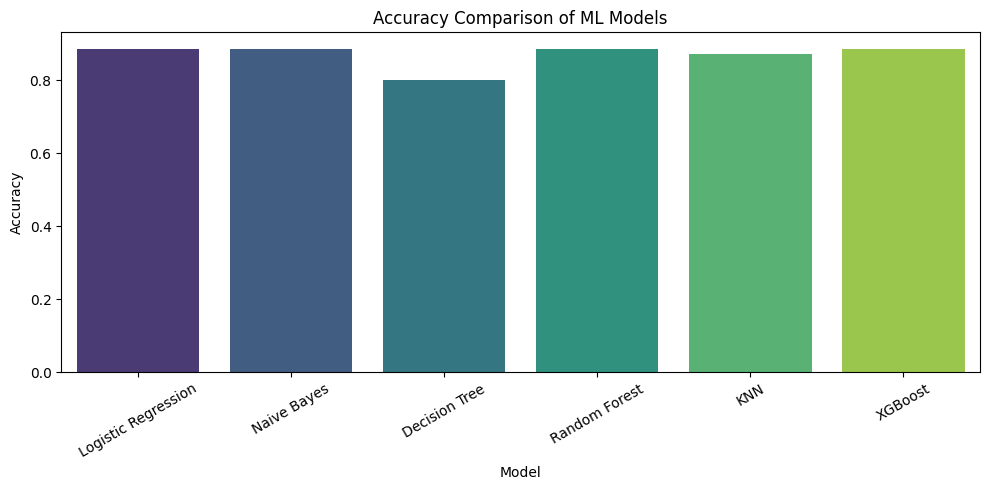

In [17]:
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.xticks(rotation=30)
plt.title("Accuracy Comparison of ML Models")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("accuracy_comparison.png")
plt.show()


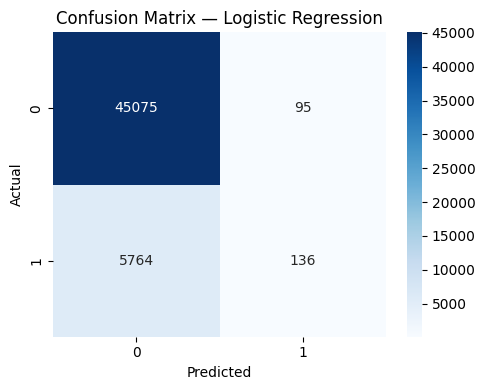

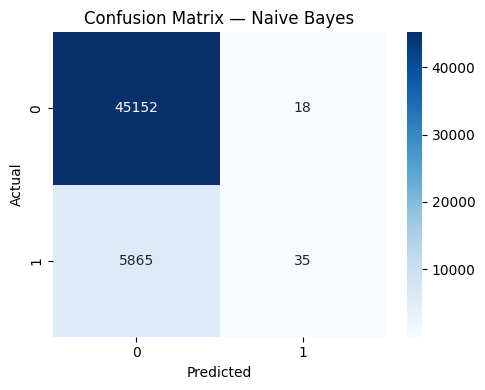

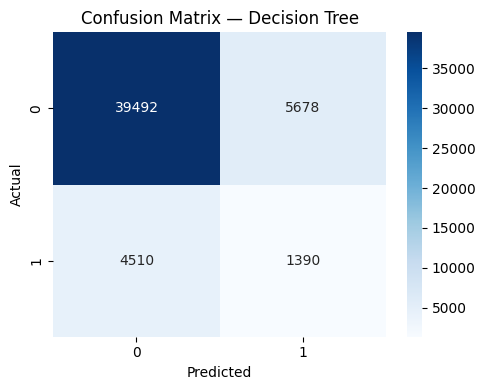

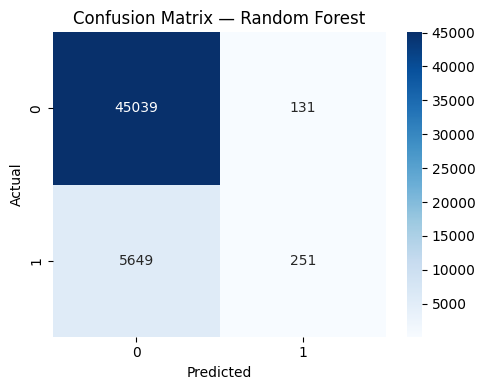

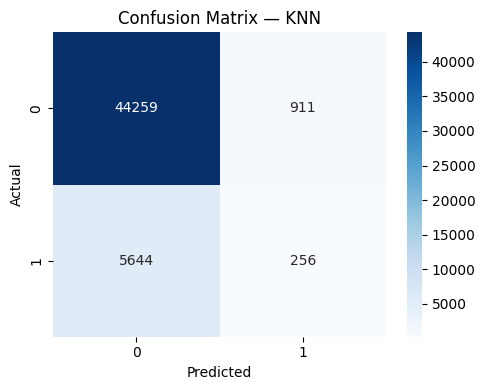

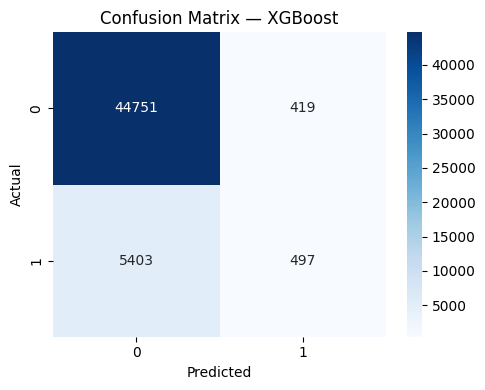

In [18]:
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()

    filename = f"confusion_matrix_{name.replace(' ', '_')}.png"
    plt.savefig(filename)

    plt.show()


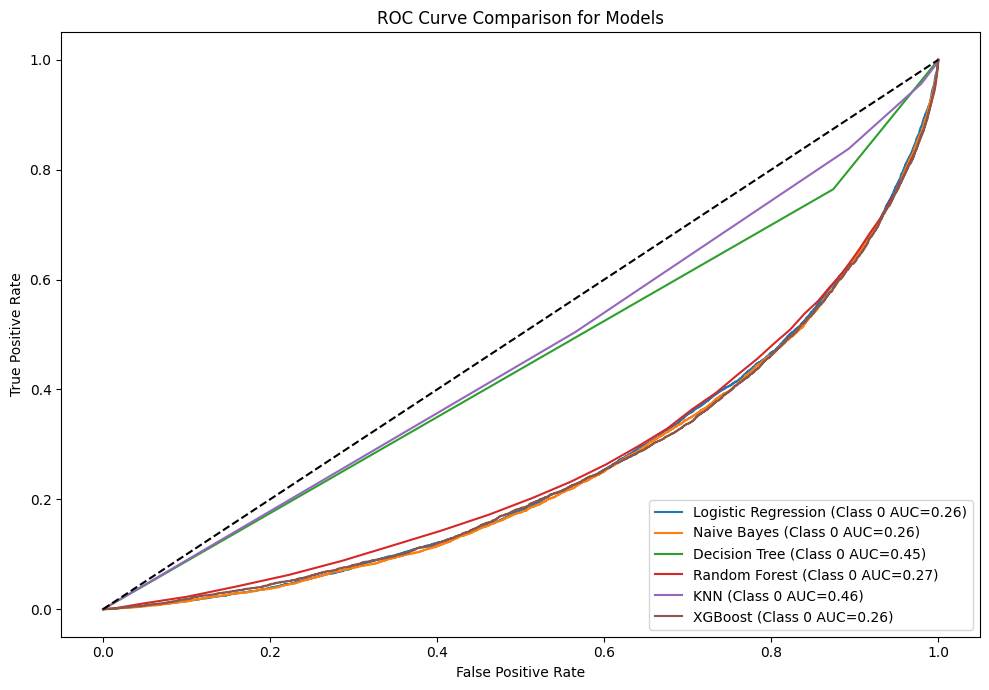

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize target for ROC curve (Multi-class support)
y_test_bin = label_binarize(y_test, classes=sorted(y.unique()))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10,7))

for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        continue

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc_score = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{name} (Class {i} AUC={auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison for Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve_comparison.png")
plt.show()


C:\Users\saich\AppData\Local\Temp\ipykernel_2520\1420378714.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=rf_importance_df, palette="coolwarm")


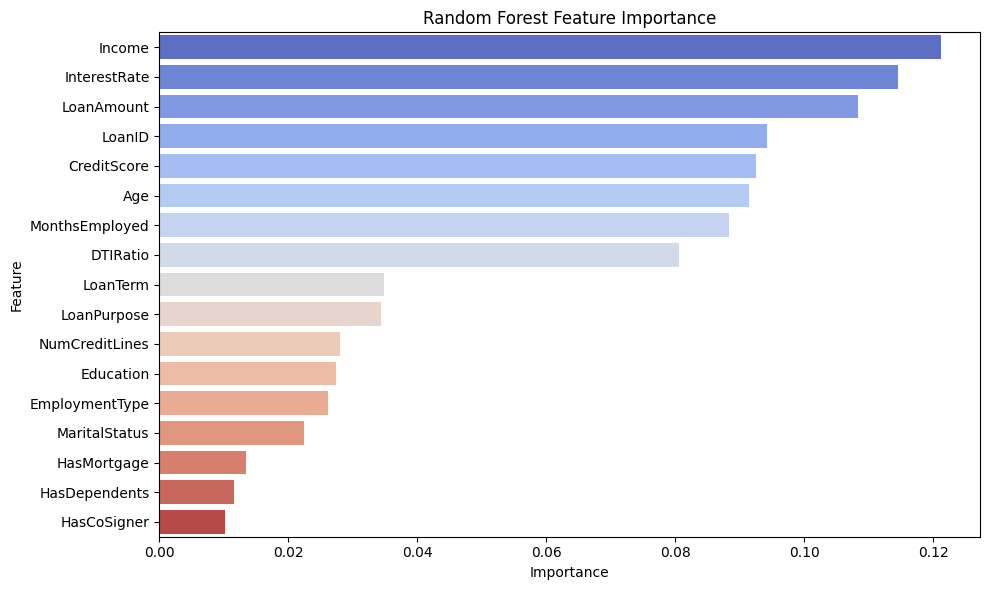

In [20]:
rf_model = trained_models["Random Forest"]
importances = rf_model.feature_importances_
feature_names = X_train.columns

rf_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=rf_importance_df, palette="coolwarm")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig("random_forest_feature_importance.png")
plt.show()


C:\Users\saich\AppData\Local\Temp\ipykernel_2520\4230815341.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=xgb_importance_df, palette="viridis")


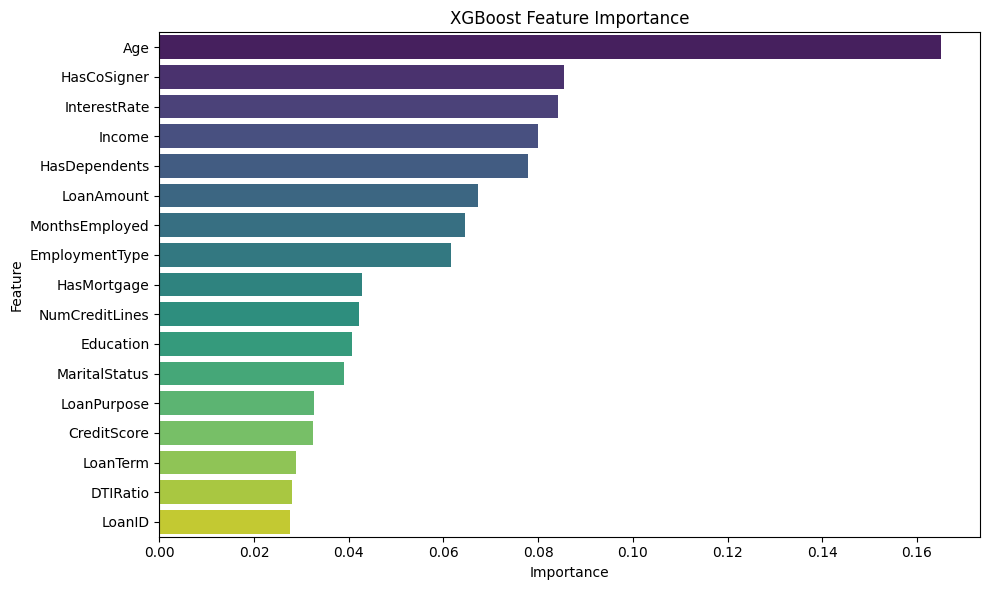

In [21]:
xgb_model = trained_models["XGBoost"]

importances = xgb_model.feature_importances_
feature_names = X_train.columns

xgb_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=xgb_importance_df, palette="viridis")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.savefig("xgboost_feature_importance.png")
plt.show()


C:\Users\saich\AppData\Local\Temp\ipykernel_2520\184699638.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=dt_importance_df, palette="plasma")


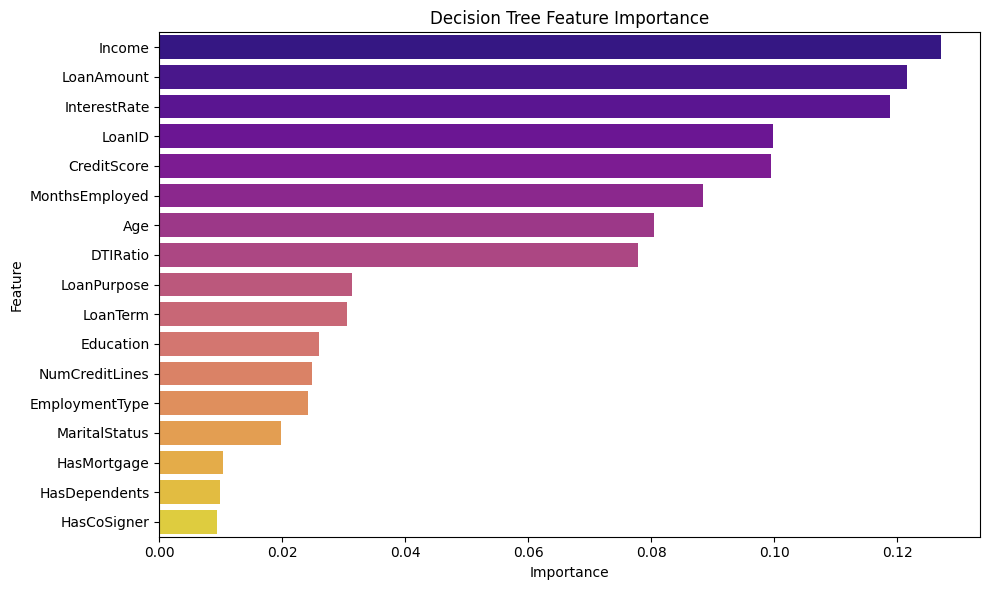

In [22]:
# DECISION TREE FEATURE IMPORTANCE
dt_model = trained_models["Decision Tree"]

importances = dt_model.feature_importances_
feature_names = X_train.columns

dt_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=dt_importance_df, palette="plasma")
plt.title("Decision Tree Feature Importance")
plt.tight_layout()
plt.savefig("decision_tree_feature_importance.png")
plt.show()
